# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
from csv import reader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import math
import random
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-11 12:49:21.009541
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10
SPLITS=3
EMBED_DIMEN=16

from cell_lines import Cell_Lines

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'
COUNTS_FILE=f"cds.kmer_counts.k{K}.npy"

In [4]:
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_number = 0
cell_line_name = all_cell_lines[cell_line_number]
print('Cell line for today:',cell_line_number,cell_line_name)

Cell line for today: 0 A549


## Load labels and sequences

In [5]:
RCI_THRESHOLDS=(-1,1)
def load_labels(atlas_file,cells):
    gene_labels = {}
    with open(atlas_file,'r') as atlas:
        header = None
        genes_considered = 0
        positives = 0
        csv = reader(atlas)
        for row in csv:
            if header is None:
                header = row
            else:
                gene = row[0]
                genes_considered += 1
                rci = float(row[1+cells])
                if not math.isnan(rci):
                    # GENERATE BINARY LABELS
                    if rci < RCI_THRESHOLDS[0]:
                        label = 0   # RCI<0
                        gene_labels[gene]=label
                    elif rci >= RCI_THRESHOLDS[1]:
                        label = 1   #RCI>=0
                        positives += 1
                        gene_labels[gene]=label
    print('ATLAS Genes:',genes_considered)
    print('Filter for genes with RCI labels from cell line:',cells)
    print('Labeled genes:',len(gene_labels))
    print('Positive labels:',positives)
    return gene_labels
    
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = load_labels(atlas_path,cell_line_number)

2022-10-11 12:49:29.877463
ATLAS Genes: 14216
Filter for genes with RCI labels from cell line: 0
Labeled genes: 4042
Positive labels: 1898


In [6]:
def load_sequences(gencode_file,labeled_genes):
    gid_tid = []
    with open(gencode_file,'r') as gencode:
        header = None
        csv = reader(gencode)
        rownum = 0
        for row in csv:
            if header is None:
                header = row
            else:
                tran_id = row[0]
                gene_id = row[1]
                if gene_id in labeled_genes:
                    label = labeled_genes[gene_id]
                    gid_tid.append((gene_id,tran_id,rownum,label))
            rownum += 1
    return gid_tid

In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
gid_tid_row_label = \
    load_sequences(gencode_path,gene_to_label)
print(datetime.now())

2022-10-11 12:49:29.967292
2022-10-11 12:49:31.395272


In [8]:
print(datetime.now())
INPUT_BINARY = GENCODE_DIR+COUNTS_FILE
ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
print(datetime.now())

2022-10-11 12:49:31.405380
2022-10-11 12:49:31.953409


## Build model

In [9]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [10]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    # PARTITIONS=1   # for testing
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        # this is complaining about string to float
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


In [11]:
splitter=Splitter(gid_tid_row_label,ordered_kmer_counts)

2022-10-11 12:49:32.027939
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________


2022-10-11 12:49:32.059517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Cross valiation
Fold 0
Train set ones/size 7190 / 15923
Valid set ones/size 1689 / 3984
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
498/498 [==============================] - 2s 3ms/step - loss: 0.5351 - accuracy: 0.7431 - val_loss: 0.5051 - val_accuracy: 0.7743
Epoch 2/10
498/498 [==============================] - 2s 3ms/step - loss: 0.4992 - accuracy: 0.7751 - val_loss: 0.4961 - val_accuracy: 0.7779
Epoch 3/10
498/498 [==============================] - 1s 2ms/step - loss: 0.4882 - accuracy: 0.7793 - val_loss: 0.4944 - val_accuracy: 0.7794
Epoch 4/10
498/498 [==============================] - 1s 2ms/step - loss: 0.4748 - accuracy: 0.7885 - val_loss: 0.4951 - val_accuracy: 0.7831
Epoch 5/10
498/498 [==============================] - 2s 3ms/step - loss: 0.4629 - accuracy: 0.7982 - val_loss: 0.5014 - val_accuracy: 0.7766
Epoch 6/10
498/498 [==============================] - 2s 3ms/step - loss: 0.4531 - accuracy: 0.8007 - val_loss: 0.5095 - val_accuracy: 0.7733
Epoch 7/10
498/4

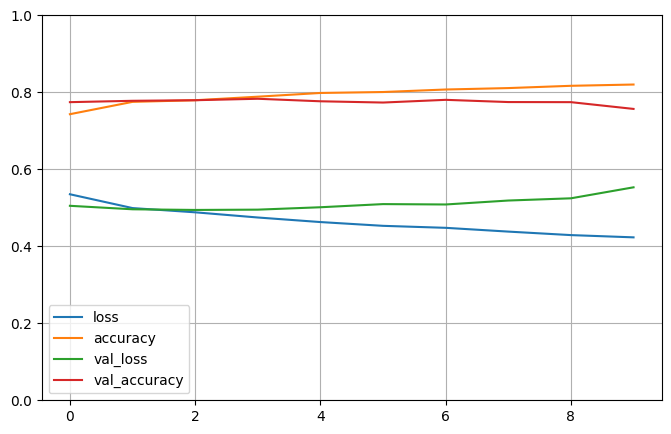

accuracy: 75.68%
Fold 1
Train set ones/size 7083 / 16085
Valid set ones/size 1796 / 3822
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
503/503 [==============================] - 2s 3ms/step - loss: 0.5434 - accuracy: 0.7399 - val_loss: 0.5231 - val_accuracy: 0.7499
Epoch 2/10
503/503 [==============================] - 1s 3ms/step - loss: 0.4922 - accuracy: 0.7758 - val_loss: 0.5132 - val_accuracy: 0.7619
Epoch 3/10
503/503 [==============================] - 2s 3ms/step - loss: 0.4803 - accuracy: 0.7853 - val_loss: 0.5334 - val_accuracy: 0.7425
Epoch 4/10
503/503 [==============================] - 1s 3ms/step - loss: 0.4712 - accuracy: 0.7871 - val_loss: 0.5237 - val_accuracy: 0.7572
Epoch 5/10
503/503 [==============================] - 1s 3ms/step - loss: 0.4683 - accuracy: 0.7922 - val_loss: 0.5243 - val_accuracy: 0.7538
Epoch 6/10
503/503 [==============================] - 1s 3ms/step - loss: 0.4542 - accuracy: 0.8023 - val_loss: 0.5220 - val_accuracy: 0.7559
Epoch 7/10
503/503 [

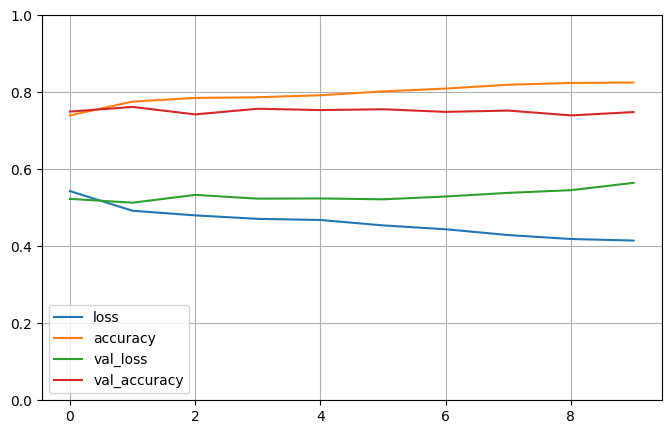

accuracy: 74.86%
Fold 2
Train set ones/size 7064 / 15863
Valid set ones/size 1815 / 4044
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
496/496 [==============================] - 2s 3ms/step - loss: 0.5298 - accuracy: 0.7493 - val_loss: 0.5192 - val_accuracy: 0.7601
Epoch 2/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4931 - accuracy: 0.7768 - val_loss: 0.5257 - val_accuracy: 0.7614
Epoch 3/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4828 - accuracy: 0.7825 - val_loss: 0.5220 - val_accuracy: 0.7668
Epoch 4/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4760 - accuracy: 0.7866 - val_loss: 0.5326 - val_accuracy: 0.7480
Epoch 5/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4646 - accuracy: 0.7922 - val_loss: 0.5258 - val_accuracy: 0.7616
Epoch 6/10
496/496 [==============================] - 1s 2ms/step - loss: 0.4518 - accuracy: 0.8022 - val_loss: 0.5589 - val_accuracy: 0.7404
Epoch 7/10
496/496 [

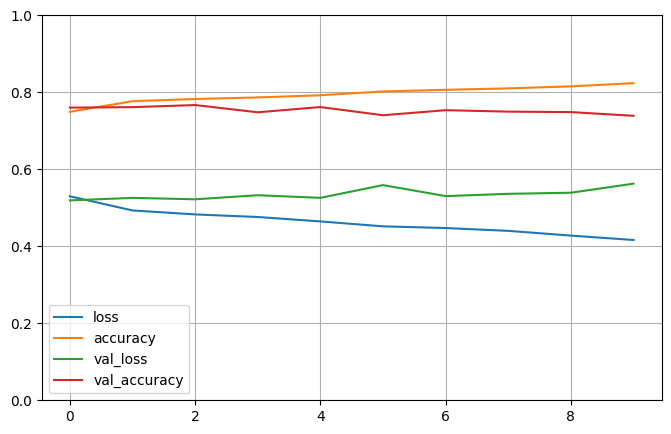

accuracy: 73.89%
Fold 3
Train set ones/size 7013 / 15879
Valid set ones/size 1866 / 4028
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
497/497 [==============================] - 2s 3ms/step - loss: 0.5337 - accuracy: 0.7458 - val_loss: 0.5050 - val_accuracy: 0.7711
Epoch 2/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4981 - accuracy: 0.7725 - val_loss: 0.5111 - val_accuracy: 0.7629
Epoch 3/10
497/497 [==============================] - 1s 2ms/step - loss: 0.4876 - accuracy: 0.7791 - val_loss: 0.5222 - val_accuracy: 0.7617
Epoch 4/10
497/497 [==============================] - 1s 2ms/step - loss: 0.4861 - accuracy: 0.7824 - val_loss: 0.5113 - val_accuracy: 0.7646
Epoch 5/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4758 - accuracy: 0.7912 - val_loss: 0.5103 - val_accuracy: 0.7696
Epoch 6/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4676 - accuracy: 0.7961 - val_loss: 0.5086 - val_accuracy: 0.7676
Epoch 7/10
497/497 [

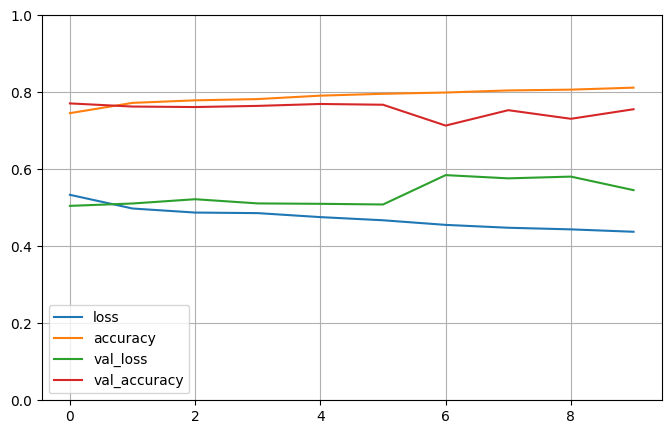

accuracy: 75.60%
Fold 4
Train set ones/size 7166 / 15878
Valid set ones/size 1713 / 4029
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
497/497 [==============================] - 2s 3ms/step - loss: 0.5279 - accuracy: 0.7520 - val_loss: 0.5300 - val_accuracy: 0.7518
Epoch 2/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4937 - accuracy: 0.7775 - val_loss: 0.5297 - val_accuracy: 0.7431
Epoch 3/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4871 - accuracy: 0.7834 - val_loss: 0.5211 - val_accuracy: 0.7615
Epoch 4/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4788 - accuracy: 0.7898 - val_loss: 0.5357 - val_accuracy: 0.7565
Epoch 5/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4653 - accuracy: 0.7955 - val_loss: 0.5204 - val_accuracy: 0.7620
Epoch 6/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4527 - accuracy: 0.8045 - val_loss: 0.5460 - val_accuracy: 0.7575
Epoch 7/10
497/497 [

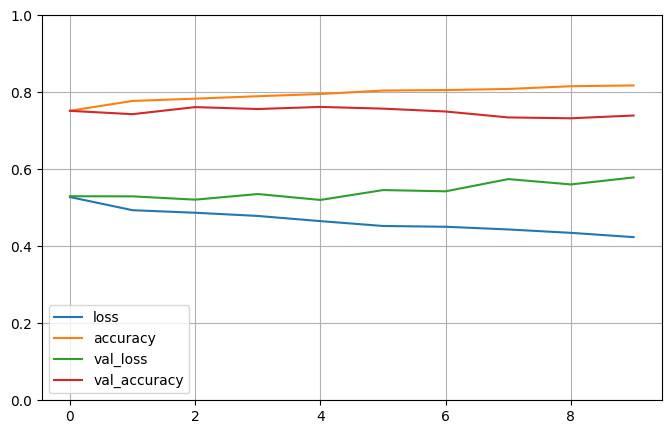

accuracy: 73.96%

Validation core mean 74.80% (+/- 0.77%)
2022-10-11 12:50:48.071253


In [12]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 